# Data Structures - 
https://mlfinlab.readthedocs.io/en/latest/feature_engineering/data_structures.html#

## Structuring Candlesticks
The point of this section is to explore alternative ways of representing candlesticks that yield strong statistical properties.

The returns from volume and dollar bars tend to produce normal distributions when compared to their timeseries counterparts.

Below, I've created volume and dollar bars using BTC-USDT price data obtained from the
Binance exchange. Each cell looks at the serial correlation and distribution of returns of each type of standard bar.

Ideally, we'll use the candlesticks that elicit the best properties moving forward.

In [1]:

import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import plotting

from exchanges import Binance

# I like to define these first, just so I don't have to later on
COLOURS = {
    "general": ["#3C8280", "#FAB131", "#ED5A3F"],
    "greens": ["#3C8280", "#7CB7B6", "#E5F1F0"],
    "reds": ["#ED5A3F", "#F27C5E", "#FBDED9"],
    "yellows": ["#FAB131", "#FBBC50", "#FDD898"],
}


def calculate_log_returns(series: pd.Series):
    return series.apply(np.log).diff().replace(np.nan, 0)


def plot_autocorrelation(
    series: pd.Series, ax: plt.Axes, xlim=50, ylim=0.1
) -> plt.Axes:

    plotting.autocorrelation_plot(series, ax=ax, color=COLOURS["reds"][1])
    ax.set_xlim([1, xlim])
    ax.set_ylim([-ylim, ylim])

    return ax


# Timeseries Bars (15 minutes per bar)

,open,high,low,close,volume,n_trades,close_time,log_returns
date,,,,,,,,
2017-08-17 04:29:59,4261.48,4280.56,4261.32,4261.45,11.308926,49,1502944199,0.000000
2017-08-17 04:29:59,4261.48,4280.56,4261.32,4261.45,11.308926,49,1502944199,0.000000
2017-08-17 04:59:59,4280.00,4313.62,4267.99,4308.83,35.872083,122,1502945999,0.011057
2017-08-17 05:29:59,4308.83,4328.69,4304.31,4320.00,21.048648,73,1502947799,0.002589
2017-08-17 05:59:59,4320.00,4320.00,4291.37,4315.32,2.186268,29,1502949599,-0.001084
...,...,...,...,...,...,...,...,...
2021-06-03 18:59:59,38676.36,38679.69,38522.72,38553.01,1095.797474,33724,1622746799,-0.003194
2021-06-03 19:29:59,38553.00,38674.15,38481.21,38602.57,922.400103,34799,1622748599,0.001285
2021-06-03 19:59:59,38602.58,38650.00,38450.00,38596.64,892.448984,32387,1622750399,-0.000154


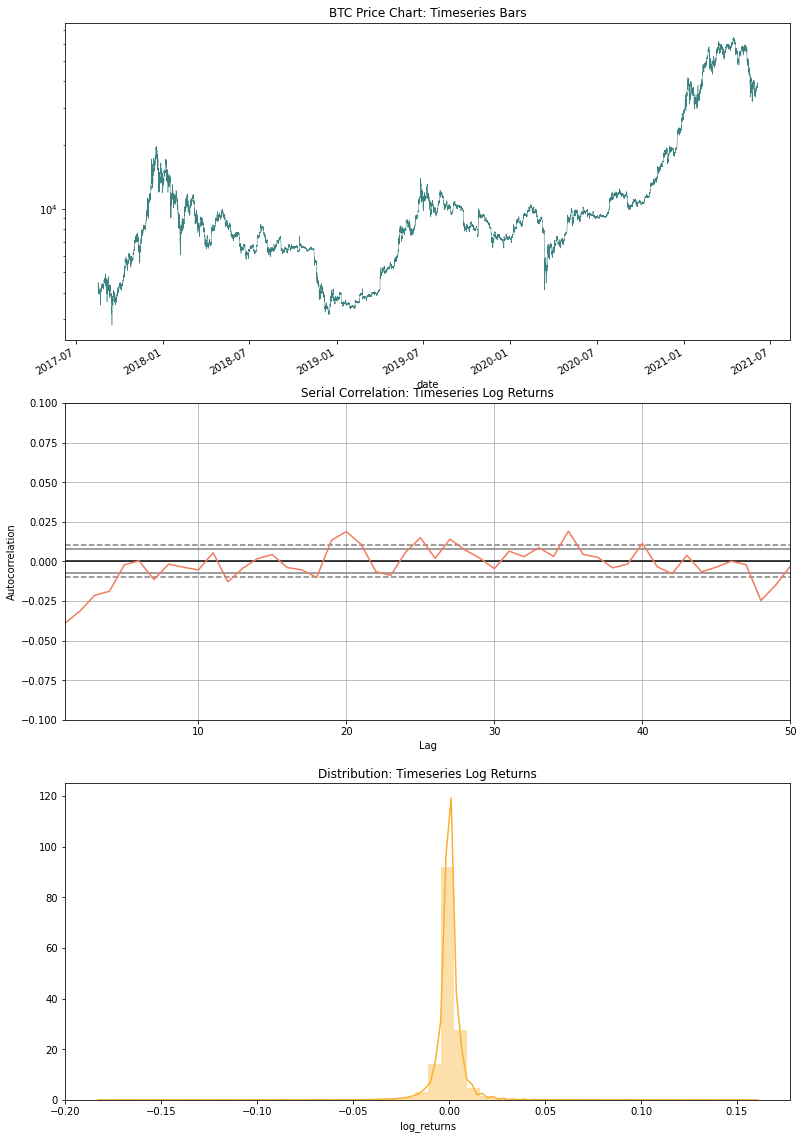

In [2]:
# Initialize an exchange
binance = Binance()
# Get bitcoin price data from binance
btc_usdt = binance.get_historical("BTCUSDT", interval="30m")

# Piecing together a dataframe with the price data
dataset = pd.DataFrame([candle.to_dict() for candle in btc_usdt]).set_index("date")
dataset["log_returns"] = calculate_log_returns(dataset.close)

# Plot the candles nicely
fig, axes = plt.subplots(3, figsize=(13, 22))
ax = dataset["close"].plot(linewidth=0.5, ax=axes[0], color=COLOURS["greens"][0])
ax.set_yscale("log")
ax.set_title("BTC Price Chart: Timeseries Bars")
ax = plot_autocorrelation(dataset.log_returns, ax=axes[1])
ax.set_title("Serial Correlation: Timeseries Log Returns")
ax = sns.distplot(dataset.log_returns, ax=axes[2], color=COLOURS["yellows"][0])
ax.set_title("Distribution: Timeseries Log Returns")

dataset


# Volume Bars
Note the differences between the histograms!

This suggests that volume bars exhibit better statistical properties

Potential Problem!!
Because of how the trading volume of Bitcoin continues to increase, these bars tend to undersample the beginning of the dataset

,open,high,low,close,volume,n_trades,close_time,log_returns
date,,,,,,,,
2017-10-14 21:59:59,4261.48,5846.17,2817.00,5759.98,49646.588438,421598,1508018399,0.000000
2017-11-11 00:29:59,5750.01,7770.02,5037.95,6534.86,49674.932582,341465,1510360199,0.126217
2017-11-25 10:29:59,6527.40,8448.99,5325.01,8397.00,49690.977641,257123,1511605799,0.250724
2017-12-02 22:59:59,8396.98,11300.03,8288.00,10946.91,49693.705717,220895,1512255599,0.265183
2017-12-09 03:59:59,10946.88,17204.99,10500.00,15502.56,49879.858678,295769,1512791999,0.347948
...,...,...,...,...,...,...,...,...
2021-06-01 00:29:59,36759.51,37745.21,36333.44,37732.79,52099.033740,1127135,1622507399,0.026133
2021-06-01 14:29:59,37725.19,37894.81,35666.00,36852.81,52007.249761,1136429,1622557799,-0.023598
2021-06-02 08:59:59,36852.81,37473.29,35716.66,37371.01,50456.478951,1050552,1622624399,0.013963


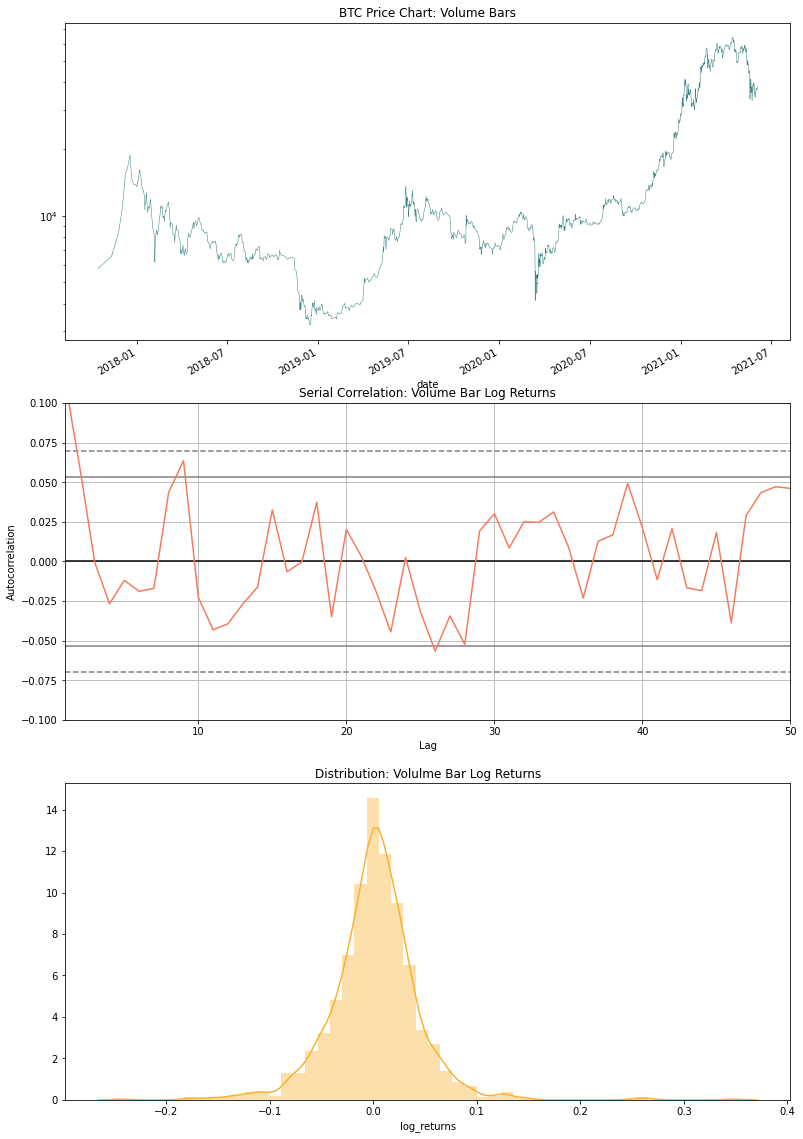

In [3]:
# Check this out for a likely much better implementation
# https://mlfinlab.readthedocs.io/en/latest/feature_engineering/data_structures.html#volume-bars
def create_volume_bars(base_bars: list, amount: int) -> iter:
    """A generator that will produce volume bars given a threshold amount

    ARGS:
        base_bars (list:BaseBar): tick ohlcv / most granular type of bar you can get

        amount (float): 1/50 of the average daily volume is suggested

    """
    deque = collections.deque(base_bars)
    volume_bar = deque.popleft()

    while deque:
        if volume_bar.volume < amount:
            volume_bar += deque.popleft()
        else:
            yield volume_bar
            volume_bar = deque.popleft()


# Average Daily Volume
# How much volume each candlestick will contain
daily_volume = dataset.resample("1D").agg({"volume": "sum"})
volume_amount = daily_volume.mean()[0]
# Volume Bar Basebar objects
volume_base = create_volume_bars(btc_usdt, volume_amount)
# Dataframe
volume_bars = pd.DataFrame([bar.to_dict() for bar in volume_base]).set_index("date")
volume_bars["log_returns"] = calculate_log_returns(volume_bars.close)


fig, axes = plt.subplots(3, figsize=(13, 22))
ax = volume_bars["close"].plot(linewidth=0.5, ax=axes[0], color=COLOURS["greens"][0])
ax.set_yscale("log")
ax.set_title("BTC Price Chart: Volume Bars")
ax = plot_autocorrelation(volume_bars.log_returns, ax=axes[1])
ax.set_title("Serial Correlation: Volume Bar Log Returns")
ax = sns.distplot(volume_bars.log_returns, ax=axes[2], color=COLOURS["yellows"][0])
ax.set_title("Distribution: Volulme Bar Log Returns")

volume_bars


# Dollar Bars

Notes:
- I didn't use the suggested dollar bar theshold of 1/50 the average daily dollar volume
- Dollar bars still seem to have better statistical properties
- Confidence around serial correlation seems lower than what was seen with volume bars.

,open,high,low,close,volume,n_trades,close_time,log_returns
date,,,,,,,,
2017-09-30 18:29:59,4261.48,4939.19,2817.00,4379.92,37612.172424,296782,1506796199,0.000000
2017-10-24 15:29:59,4374.99,6171.00,4110.00,5623.04,29247.233826,228332,1508858999,0.249842
2017-11-07 03:29:59,5623.04,7590.25,5286.98,7099.99,23269.470459,169321,1510025399,0.233221
2017-11-16 03:59:59,7112.54,7770.02,5325.01,7239.00,22745.945039,155704,1510804799,0.019390
2017-11-21 08:59:59,7219.52,8319.99,7145.00,8210.98,20159.325267,100197,1511254799,0.125989
...,...,...,...,...,...,...,...,...
2021-06-03 12:59:59,38781.75,39090.90,38555.00,38999.01,4793.181879,77004,1622725199,0.005586
2021-06-03 13:59:59,38999.01,39265.25,38288.00,38440.01,7469.567001,115192,1622728799,-0.014437
2021-06-03 15:59:59,38440.00,38768.20,38343.54,38535.61,5198.582836,244319,1622735999,0.002484


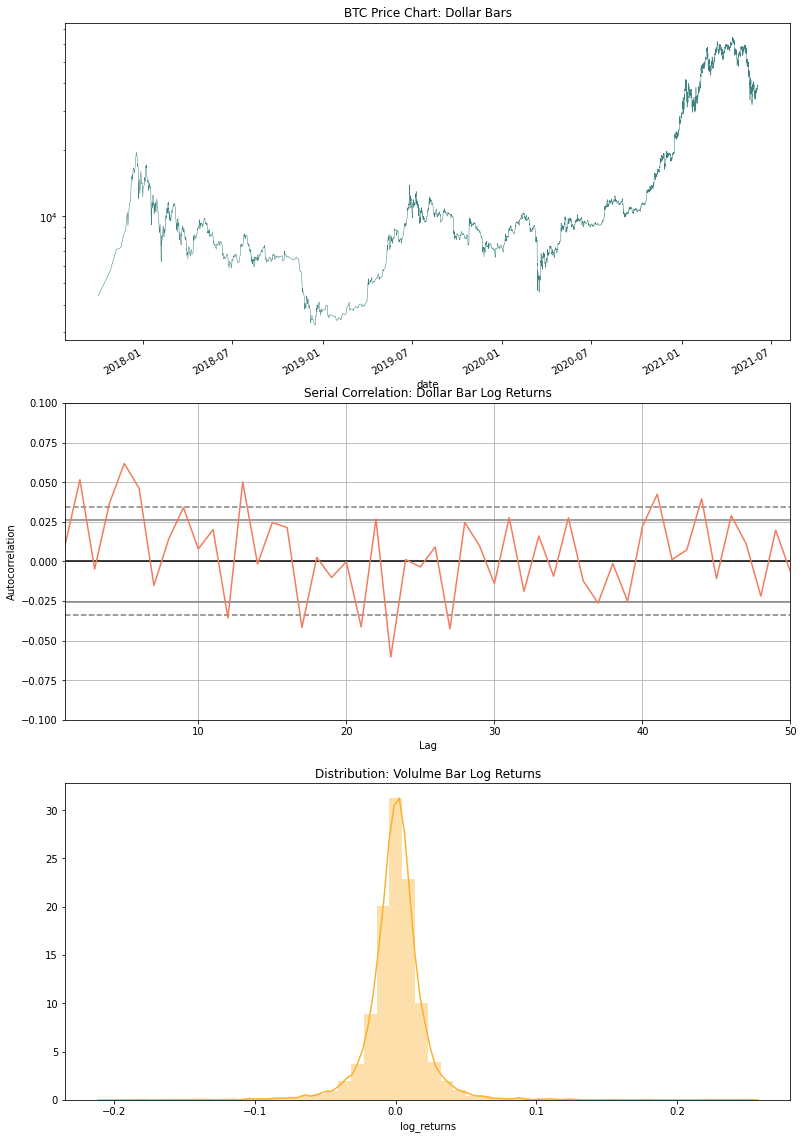

In [6]:

def create_dollar_bars(base_bars: list, amount: int) -> iter:
    """A generator that will produce dollar bars given a threshold amount

    ARGS:
        base_bars (list:BaseBar): tick ohlcv / most granular type of bar you can get

        amount (float): 1/50 of the average daily dollar volume is suggested

    """
    deque = collections.deque(base_bars)
    dollar_bar = deque.popleft()

    while deque:
        if dollar_bar.volume * dollar_bar.close < amount:
            dollar_bar += deque.popleft()
        else:
            yield dollar_bar
            dollar_bar = deque.popleft()


# How much dollar_volume each candlestick will contain
daily_volume = dataset.resample("1D").agg({"volume": "sum", "close": "last"})
daily_dollar = daily_volume["volume"] * daily_volume["close"]
daily_dollar_mean = daily_dollar.mean() / 5

# Dollar Bar Basebar objects
dollar_base = create_dollar_bars(btc_usdt, daily_dollar_mean)
# Dataframe
dollar_bars = pd.DataFrame([bar.to_dict() for bar in dollar_base]).set_index("date")
dollar_bars["log_returns"] = calculate_log_returns(dollar_bars.close)

# Plotting
fig, axes = plt.subplots(3, figsize=(13, 22))
ax = dollar_bars["close"].plot(linewidth=0.5, ax=axes[0], color=COLOURS["greens"][0])
ax.set_yscale("log")
ax.set_title("BTC Price Chart: Dollar Bars")
ax = plot_autocorrelation(dollar_bars.log_returns, ax=axes[1])
ax.set_title("Serial Correlation: Dollar Bar Log Returns")
ax = sns.distplot(dollar_bars.log_returns, ax=axes[2], color=COLOURS["yellows"][0])
ax.set_title("Distribution: Volulme Bar Log Returns")

dollar_bars

